In [ ]:
import pandas as pd
import openai
from keybert import KeyBERT
import langdetect
import time
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import os 
import glob

from tabgan.sampler import Sampler


from faker import Faker
import pytz
from datetime import datetime, timedelta

from transformers import pipeline

pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 200)

# model = KeyBERT('distilbert-base-nli-mean-tokens')

In [ ]:
with open("apikey_moritz.txt", "r") as f:
    api_key = f.read()

print(api_key)
openai.api_key = api_key

## Text: Finetuned GPT3 Model


In [ ]:
fine_tune_list = openai.FineTune.list()
fine_tuned_model = fine_tune_list['data'][0].fine_tuned_model
print(fine_tuned_model)

In [ ]:
new_prompt = "A Google Maps review about a steak house. ###"
answer = openai.Completion.create(
  model=fine_tuned_model,
  prompt=new_prompt,
  max_tokens=200, # Change amount of tokens for longer completion
  temperature=1,
  stop = "END"
)
print(answer['choices'][0]['text'])

In [ ]:
def gpt3_finetuned(row):
    catgeoryName = row['categoryName'].lower()
    prompt = "A Google Maps review about a " + catgeoryName + ". ###"
    print(prompt)
    answer = openai.Completion.create(
      model=fine_tuned_model,
      prompt=prompt,
      max_tokens=200, # Change amount of tokens for longer completion
      temperature=1, 
      stop = "END"
    )
    return answer['choices'][0]['text']

# def gpt3_5_turbo(row):
#     prompt = "Write a Google Maps review about a " + row['categoryName'] + ". In Style of a Google user that writes a review about a place."
#     role = "In stlye of a google user that writes a review about a place."
#     prompt = "Write a Google Maps review about a " + row['categoryName']+"."
#     print(prompt)
#     return chatGPT(api_key, role).question(prompt)

#### Outdated: Nur für Test:  gpt3_5_turbo vs gpt3_finetuned 

In [ ]:
# ## df_test.to_csv('test_df_showcase20gpt.csv')
# # print("Done with gpt3_finetuned_v1 text generation.")

# df_test = pd.read_csv('test_df_showcase.csv')
# df_test['gpt3_finetuned_v1'] = df_test.apply(gpt3_finetuned, axis=1)
# df_test.to_csv('test_df_showcase.csv')
# print("Done with gpt3.5_turbo text generation.")

# print(df_test)
# print(df_test.shape)

In [ ]:
# df_test = pd.read_csv('test_df_showcase.csv')
# df_test['gpt3.5_turbo'] = df_test['gpt3.5_turbo'].astype(str)

# for index, row in df_test.iterrows():
#     print(row['title'])
#     print(row['categoryName'])
#     print("ORG:" + row['original_text'])
#     print("GPT:" + row['gpt3_finetuned_v1'])
#     print("GPT3.5:" + row['gpt3.5_turbo'])
#     print("__________________________________________________________________________________________")

### Jetzt tatsächliche Daten augmentiert / generiert. Dazu einen neuen Dataframe erstellen...

Später wird der dann bemerged.

In [ ]:
# df_true = pd.read_csv('base_keywords_sentiment_reduced.csv')
# df_finetune = pd.read_csv('dataset_ft_v3_en_mulitmod_pc.csv.csv')

# # print(df_true['categoryName'].value_counts())
# # print(df_finetune['categoryName'].value_counts())
# print(f'True:' , df_true.shape)

# df_fake = pd.DataFrame(columns=df_true.columns)
# df_fake['categoryName'] = df_true['categoryName']
# df_fake['label'] = 'FAKE'

# # just for reference. Can be delted later on. 
# df_fake['reviewId'] = df_true['reviewId']
# df_fake['title'] = df_true['title']
# df_fake['text'] = df_true['text']
# df_fake['placeId'] = df_true['placeId']

# df_fake.to_csv('fake_base.csv', index=False)

#### Ab hier neue finetunes ausprobieren und unter neuer Version speichern. 
 Wichtig! Spaltennamen ändern von gpt3_v3

In [ ]:
df_fake = pd.read_csv('fake_base_gpt3_v2331.csv')
df_fake["prompt_v4"] = "A Google Maps review about a " + df_fake["categoryName"] + ". ###"

for index, row in df_fake.iterrows():
    df_fake.at[index, 'gpt3_v4'] = gpt3_finetuned(row)
    print(df_fake.at[index, 'gpt3_v4'])
    print(index)
    if index % 50 == 0:
        df_fake.to_csv('fake_base_gpt3_v23314.csv', index=False)
        print("Wir warten ein paar Sekunden und hoffen, dass der API key deshalb nicht geblockt wird...")
        time.sleep(25)
        print("Weiter geht's...")

print("Done with gpt3 text generation.")
print(df_fake.shape)
print(df_fake.columns)

df_fake.to_csv("fake_base_gpt3_v23314.csv", index=False)

In [ ]:
# load df_fake and save in xlsx

df_fake = pd.read_csv('fake_base_gpt3_v23314.csv')
print(df_fake.shape)


# Image Generierung


Vorbereitung. Eine Sentiment-Analyse auf dem generierten Text durchführen. 

In [ ]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

In [ ]:
# do a sentiment analysis on the generated text gpt3_v2, gpt3_v3 gpt3_v3.1

df_fake = pd.read_csv('fake_base_gpt3_v23314.csv')
df_fake['sent_v2'] = np.nan
df_fake['sent_v3']= np.nan
df_fake['sent_v3.1'] = np.nan
df_fake['sent_v4'] = np.nan

df_fake['sent_v2'] = df_fake['gpt3_v2'].astype(str)
df_fake['sent_v3'] = df_fake['gpt3_v3'].astype(str)
df_fake['sent_v3.1'] = df_fake['gpt3_v3.1'].astype(str)
df_fake['sent_v4'] = df_fake['gpt3_v4'].astype(str)

for index, row in df_fake.iterrows():
    print("Processing row: ", index)
    try:
        df_fake.at[index, 'sent_v2'] = sentiment_task(row['gpt3_v2'])[0]['label']
        df_fake.at[index, 'sent_v3'] = sentiment_task(row['gpt3_v3'])[0]['label']
        df_fake.at[index, 'sent_v3.1'] = sentiment_task(row['gpt3_v3.1'])[0]['label']
        df_fake.at[index, 'sent_v4'] = sentiment_task(row['gpt3_v4'])[0]['label']
    except RuntimeError:
        print("Skipped due to messy data. Row: ", index)
        pass

df_fake.to_csv('fake_base_gpt3_v23314_sent.csv', index=False)
df_fake.to_excel('fake_base_gpt3_v23314_sent.xlsx', index=False)


## Image: Dall-E-2


In [ ]:
with open("apikey_papa.txt", "r") as f:
    openai.api_key = f.read()

In [ ]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent.csv')
print(df_fake.shape)
print(df_fake.columns)
print(df_fake['categoryName'])

In [ ]:
def generate_dalle_prompt(row):
    genre = row["genre"].lower()
    categoryName = row["categoryName"].lower()
    sentiment = row["sent_v4"].lower()
    locationString = f"a {categoryName}"
    tone = ""
    if sentiment == "positive":
        sentiment = "great"
        inspire_sentence = "This photo is sure to delight and inspire anyone who sees it"
        if genre == "restaurant":
            sentiment = "delicious"
            tone = "delicious, well-decorated"
        elif genre == "hotel":
            sentiment = "great"
            tone = "clean"
        elif genre == "activity":
            inspire_sentence = "This photo is sure to inspire anyone who sees it to do the same activity."
            sentiment = "fun"
            tone = "fun, happy athmosphere"
    elif sentiment == "negative":
        inspire_sentence = "This photo is likely to disappoint and demotivate anyone who sees it"
        sentiment = "dissappointing"
        if genre == "restaurant":
            tone = "bad service, dirty, bad decoration"
        elif genre == "hotel":
            tone = "dirty, uncomfortable"
        elif genre == "activity":
            tone = "boring, lame"
    else:
        inspire_sentence = ""
        sentiment = "average"

    if genre == "restaurant":
       # PROMPT = f"A makro of {sentiment} food at a {categoryName}, {tone}, {inspire_sentence}, Sigma 105mm F2.8, close-up, hyper detailed, Super-Resolution, UHD, DTM, HDR, 8K --ar 4:3 --q 2, on Tripadvisor.com in 2022"
        PROMPT =  f"A photo of {sentiment} food at a {categoryName}. {inspire_sentence}. The shot is taken with a Canon EOS 5D Mark IV camera and a 40mm f/1.8 lens, with settings of f/5.6, ISO 100, and a shutter speed of 1/200 sec. Close-up, Super-Resolution, UHD, DTM, HDR, 8K --ar 4:3 --q 2,  on Tripadvisor.com 2022"
    elif genre == "hotel":
        PROMPT = f"A photo of {sentiment} stay at a {categoryName}, {inspire_sentence}. Sigma lens, wide shot, full shot. hyper detailed, Super-Resolution, UHD, DTM, HDR, 8K --ar 4:3 --q 2, on Bookings.com in 2022"
    elif genre == "activity":
        PROMPT = f"A photo of a {categoryName} taken by a photograph visitor. The shot is taken with a Canon EOS 5D Mark IV camera and a 40mm f/1.8 lens, hyper detailed, Super-Resolution, UHD, DTM, HDR, 8K --ar 4:3 --q 2, on Tripadvisor.com in 2022"

    print(PROMPT)
    return PROMPT

prompt = generate_dalle_prompt(df_fake.iloc[599])
response = openai.Image.create(prompt=prompt, n=1, size="256x256")
print(response["data"][0]["url"])


In [ ]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')
print(df_fake.shape)

In [ ]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')

df_fake['fake_reviewImageUrls/0'] = ""
print(df_fake.shape)

for index, row in df_fake.iterrows():
    if  index < 449:
        print("Schon berechnet (auf anderem Account): ", index)
        continue
    print("Generating Promt for row: ", index)
    prompt = generate_dalle_prompt(row)
    df_fake.at[index, 'dalle_prompt'] = prompt
    print("Generated Image for index: ", index)
    response = openai.Image.create(prompt=prompt, n=1, size="256x256")
    df_fake.at[index, 'fake_reviewImageUrls/0'] = response["data"][0]["url"]
    response_url = response["data"][0]["url"]
    print(response["data"][0]["url"])
    df_fake.to_csv('fake_base_gpt3_v23314_sent_dalle.csv', index=False)
    print("Saved Image for index: ", index)
    print(f"_______________________NOW START DOWNLOADING FOR INDEX {index} ____________________________________________________________________")
    reviewId = row['reviewId']
    reviewIdF = row['reviewIdF']
    print(f"Downloading Image for index {index}, reviewId {reviewId}, reviewIdF {reviewIdF}...")
    print(row['fake_reviewImageUrls/0'])
    response = requests.get(response_url)
    img = Image.open(BytesIO(response.content))
    print(img.mode)
    print(img.size)
    img.save(f'fake_image_url_0/{index}_{reviewId}_fake_reviewImageUrls_0.png')
    print("Saved Image for index: ", index)
    print("_______________________________DONE___________________________________________________________")

print("Fertig mit Erzeugung von Bildern mit API über Dalle 2.")

Eveentuell die erzeugten Bilder umbennen, falls System was aus Filenamen lernt bzw es die Filenamen nicht mehr passen wegen dem zusammengeführten Index später

...rename a file from folder fake_image_url_0


In [ ]:
# for filename in glob.glob('fake_image_url_0/*.png'):
#     print(filename)
#     os.rename(filename, filename[4:])

In [ ]:
pd.set_option('display.max_colwidth', None)
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')
df_fake['githubUrls/0'] = ""
print(df_fake.shape)

for index, row in df_fake.iterrows():
    print("Generating Github Url for row: ", index)
    github_path = f"https://raw.githubusercontent.com/MichaelSeitz98/seminararbeit_review_detection/main/02_Images/fake_image_url_0/{index}_{row['reviewId']}_fake_reviewImageUrls_0.png"
    df_fake.at[index, 'githubUrls/0'] = github_path
    print(f"Generated {github_path} Github Url for index: ", index)

print("Fertig mit Erzeugung von Github Urls.")
print(df_fake["githubUrls/0"])

df_fake.to_csv('fake_base_gpt3_v23314_sent_dalle.csv', index=False)

In [ ]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')
print(df_fake.columns)
df_fake.to_excel('fake_base_gpt3_v23314_sent_dalle.xlsx', index=False)

# Tabulare Daten 

### Name und PublishedAtDate mit Faker erzeugt

Fake publishedAtDate & publishedAt Column im Fake dataset and store it in column published_at_date_column

In [ ]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')
fake = Faker('en_GB')
df_fake['fake_publishedAtDate'] = ""

end_date = datetime(2023, 3, 29)
start_date = end_date - timedelta(days=365*7)

for index, row in df_fake.iterrows():
    fake_time = fake.date_time_between(start_date=start_date, end_date=end_date, tzinfo=None)
    fake_time_str = fake_time.strftime('%Y-%m-%dT%H:%M:%S')
    df_fake.at[index, 'fake_publishedAtDate'] = fake_time_str
    print(f"Generated {fake_time_str} for index: ", index)

print("Fertig mit Erzeugung von fake publishedAtDate.")
print(df_fake["fake_publishedAtDate"])
df_fake.to_csv('fake_base_gpt3_v23314_sent_dalle.csv', index=False)

Namen auch mit Faker augmentiert.

In [ ]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')

fake = Faker('en_GB')
df_fake['fake_name'] = ""

for index, row in df_fake.iterrows():
    fake_vorname = fake.first_name()
    fake_nachname = fake.last_name()
    fake_name = fake_vorname + " " + fake_nachname
    df_fake.at[index, 'fake_name'] = fake_name
    print(f"Generated name for index {index}: {fake_name} ")

df_fake.to_csv('fake_base_gpt3_v23314_sent_dalle.csv', index=False)
print(f"Fertig mit Erzeugung von fake name: {df_fake.shape}")    

### GAN for Tabular Data (stars, likesCount, reviewerNumberOfReviews, isLocalGuide)

mit TabGAN oder CTGAN, eventuell 

Vorbereitung der tabularen GANs -> an diesem datensatz soll er sich orierntieren.

In [ ]:
df_base_tabGAN = pd.read_csv('01_Data/raw_data/dataset_für_weitere_forschung.csv')
df_real = pd.read_csv('base_keywords_sentiment_reduced.csv')

df_base_tabGAN.shape

df_base_tabGAN = df_base_tabGAN[~df_base_tabGAN['reviewId'].isin(df_real['reviewId'])]
df_base_tabGAN = df_base_tabGAN.dropn(subset=['reviewImageUrls/0'])

print(df_base_tabGAN.shape)
print(df_base_tabGAN.columns)

df_base_tabGAN.to_csv('01_Data/raw_data/base_dataset_tabGAN.csv', index=False)


oder soll ich einfach die base_keywords_sentiment_reduced.csv nehmen und darauf das TABGAN trainieren? Macht wsl mehr Sinn, dann ist


In [ ]:
df_real = pd.read_csv('base_keywords_sentiment_reduced.csv')
df_real['reviewerNumberOfReviews'].shape

### Try with CTGAN


In [ ]:
import ctgan
from ctgan import CTGAN

In [71]:
df_all_multimod = pd.read_csv('01_Data/raw_data/base_dataset_tabGAN.csv')

print(df_all_multimod.shape)
print(df_all_multimod['stars'].mean())
df_all_multimod = df_all_multimod[['stars', 'likesCount', 'reviewerNumberOfReviews', 'isLocalGuide']]
categorical_features = ['stars', 'likesCount', 'reviewerNumberOfReviews', 'isLocalGuide']

train_data['stars'] = train_data['stars'].astype('category')
train_data['likesCount'] = train_data['likesCount'].astype('float64')
train_data['reviewerNumberOfReviews'] = train_data['reviewerNumberOfReviews'].astype('float64')
train_data['isLocalGuide'] = train_data['isLocalGuide'].astype('category')

categorical_features = ['stars', 'likesCount', 'reviewerNumberOfReviews', 'isLocalGuide']

ctgan = CTGAN(verbose=True)
ctgan.fit(df_all_multimod, categorical_features, epochs = 40)

(9553, 14)
4.517743117345336
Epoch 1, Loss G:  3.0311,Loss D: -0.1715
Epoch 2, Loss G:  2.8923,Loss D: -0.2174
Epoch 3, Loss G:  2.5583,Loss D: -0.1149
Epoch 4, Loss G:  2.2632,Loss D: -0.0147
Epoch 5, Loss G:  2.4582,Loss D: -0.0049
Epoch 6, Loss G:  2.3397,Loss D: -0.0739
Epoch 7, Loss G:  2.3782,Loss D: -0.0244
Epoch 8, Loss G:  2.1343,Loss D:  0.0254
Epoch 9, Loss G:  1.9351,Loss D:  0.0195
Epoch 10, Loss G:  2.1377,Loss D:  0.0316
Epoch 11, Loss G:  1.8468,Loss D: -0.0441
Epoch 12, Loss G:  2.0414,Loss D: -0.0302
Epoch 13, Loss G:  2.0745,Loss D:  0.0458
Epoch 14, Loss G:  1.7300,Loss D:  0.0283
Epoch 15, Loss G:  1.6479,Loss D:  0.0270
Epoch 16, Loss G:  1.7771,Loss D: -0.0408
Epoch 17, Loss G:  1.8139,Loss D:  0.0218
Epoch 18, Loss G:  1.7903,Loss D: -0.0221
Epoch 19, Loss G:  1.6050,Loss D:  0.0384
Epoch 20, Loss G:  1.6177,Loss D: -0.0151
Epoch 21, Loss G:  1.3602,Loss D: -0.0050
Epoch 22, Loss G:  1.5305,Loss D:  0.0260
Epoch 23, Loss G:  1.6004,Loss D: -0.0274
Epoch 24, Loss

In [90]:
org_data = pd.read_csv('01_Data/raw_data/base_dataset_tabGAN.csv')

samples = ctgan.sample(705)
print(samples)

print(f"Fake Data mit mean (stars): {samples['stars'].mean()}")
print(f"Orgi Data mit mean (stars): {org_data['stars'].mean()}")
print(f"Fake Data mit mean (likesCount): {samples['likesCount'].mean()}")
print(f"Orgi Data mit mean (likesCount): {org_data['likesCount'].mean()}")
print(f"Fake Data mit mean (reviewerNumberOfReviews): {samples['reviewerNumberOfReviews'].mean()}")
print(f"Orgi Data mit mean (reviewerNumberOfReviews): {org_data['reviewerNumberOfReviews'].mean()}")
print(f"Fake Data mit mean (isLocalGuide): {samples['isLocalGuide'].mean()}")
print(f"Orgi Data mit mean (isLocalGuide): {org_data['isLocalGuide'].mean()}")

samples.to_csv('01_Data/raw_data/fake_metadata_ctgan_stars_likes_reviewernr_localguide.csv', index=False)

print(samples.shape)
# how many numerical features are there 

# list dtypes 
print(samples.dtypes)
print(samples.select_dtypes(include=['float64']).shape[1])

     stars  likesCount  reviewerNumberOfReviews  isLocalGuide
0   4.0000      0.0000                 284.0000          True
1   5.0000      1.0000                 371.0000          True
2   3.0000      3.0000                  53.0000          True
3   3.0000     25.0000                 616.0000         False
4   5.0000      0.0000                  33.0000          True
..     ...         ...                      ...           ...
700 3.0000      0.0000                 608.0000         False
701 4.0000      0.0000                  31.0000          True
702 1.0000      0.0000                 299.0000         False
703 5.0000      0.0000                 114.0000         False
704 4.0000      3.0000                  68.0000          True

[705 rows x 4 columns]
Fake Data mit mean (stars): 4.089361702127659
Orgi Data mit mean (stars): 4.517743117345336
Fake Data mit mean (likesCount): 1.0141843971631206
Orgi Data mit mean (likesCount): 0.6657594472940438
Fake Data mit mean (reviewerNumberOf

(9553, 4) (705, 4)
Index(['stars', 'likesCount', 'reviewerNumberOfReviews', 'isLocalGuide'], dtype='object')


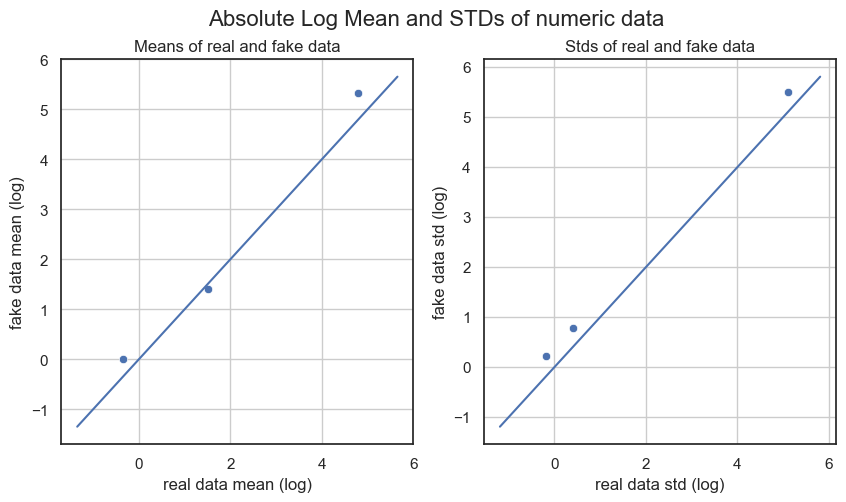

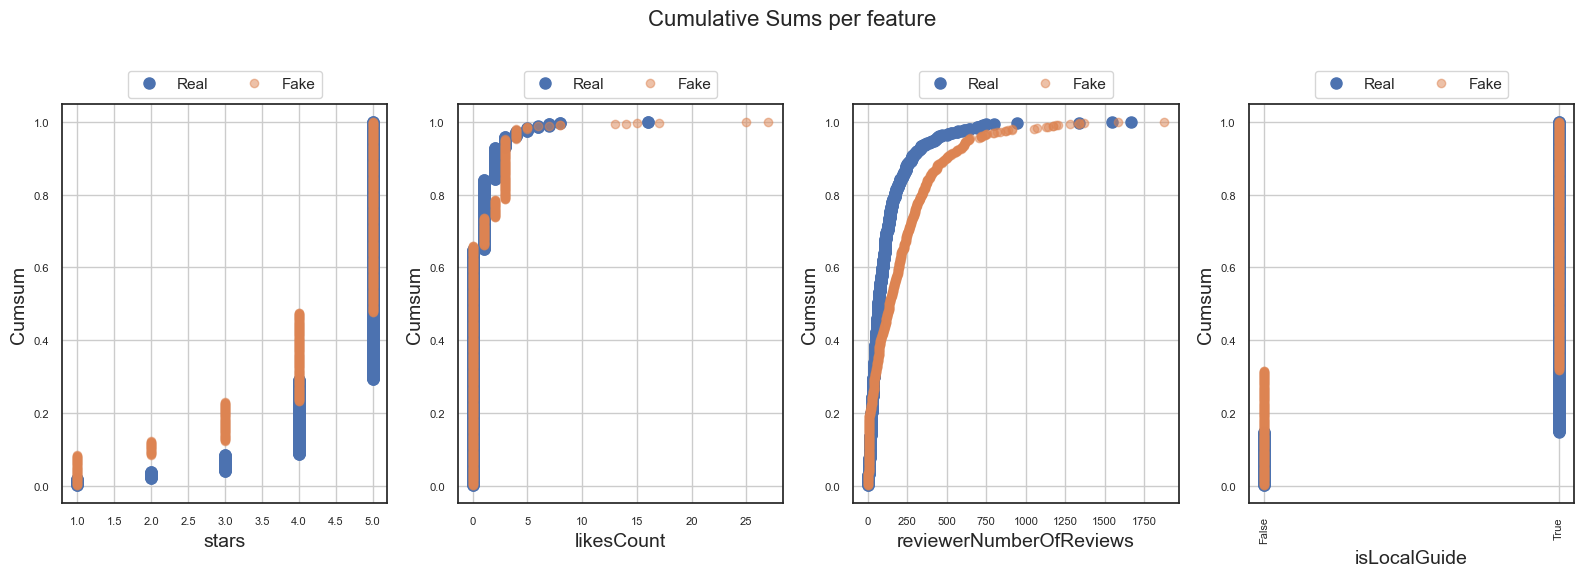

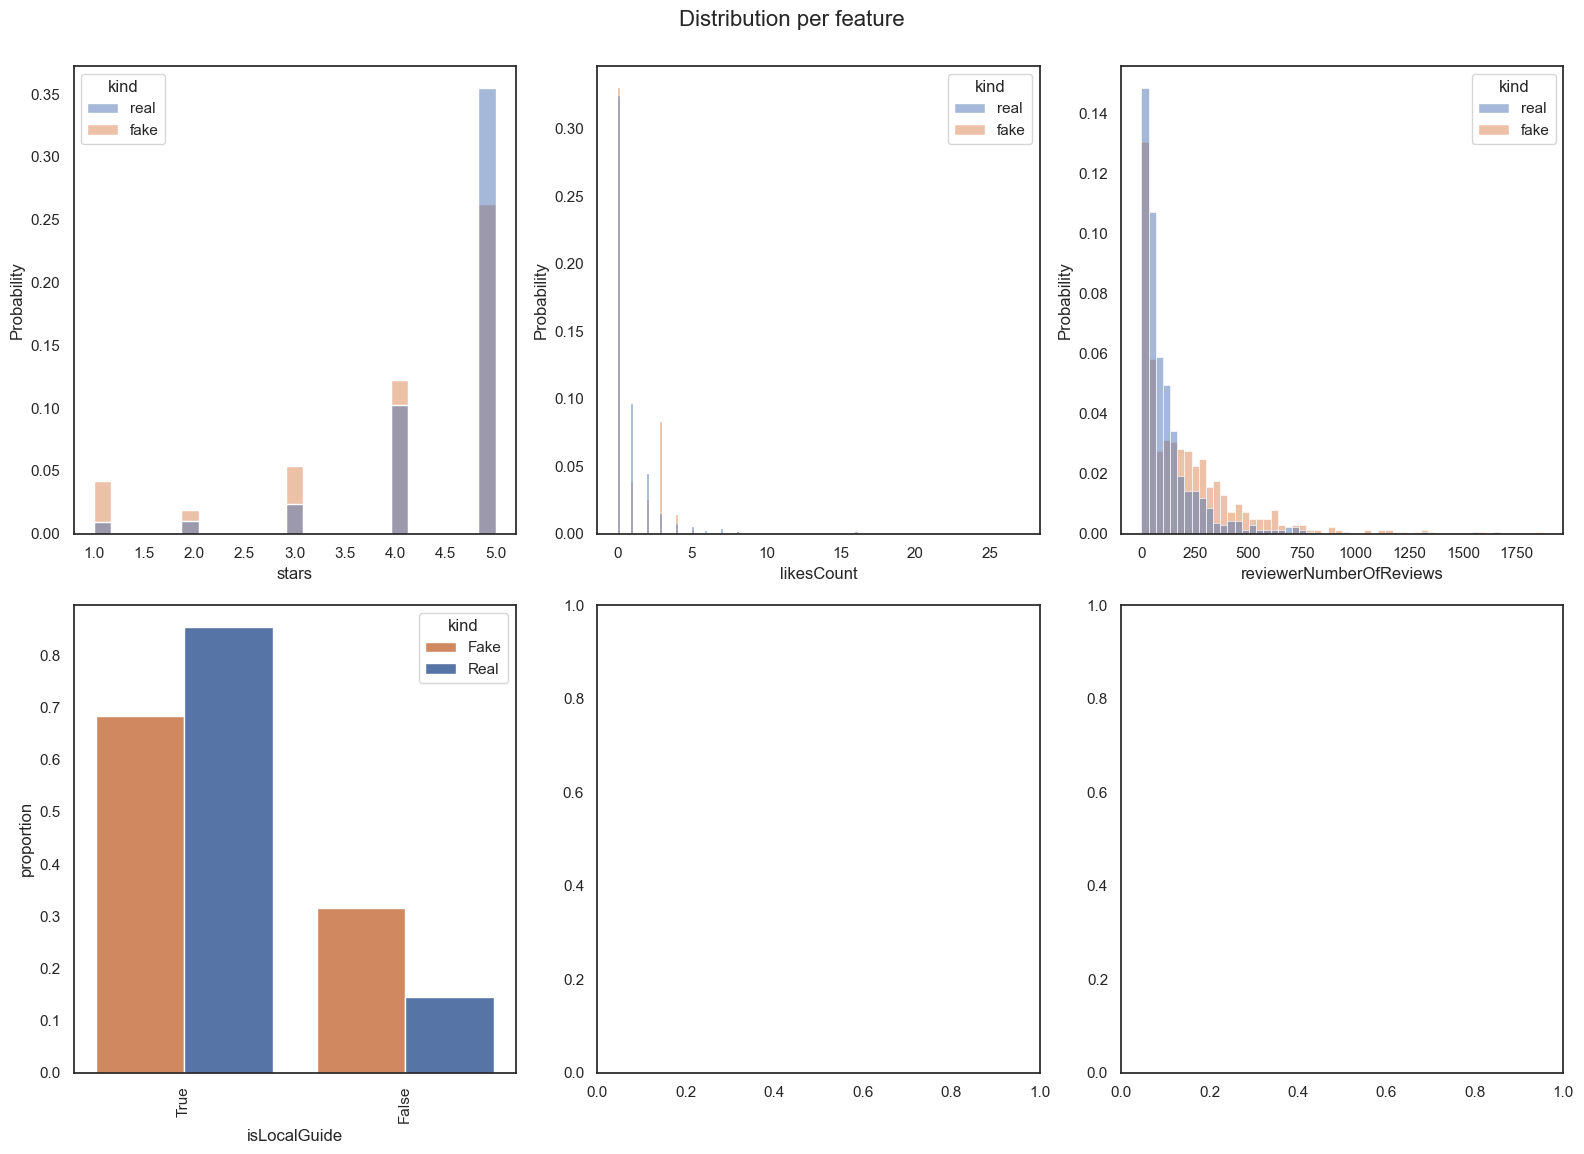

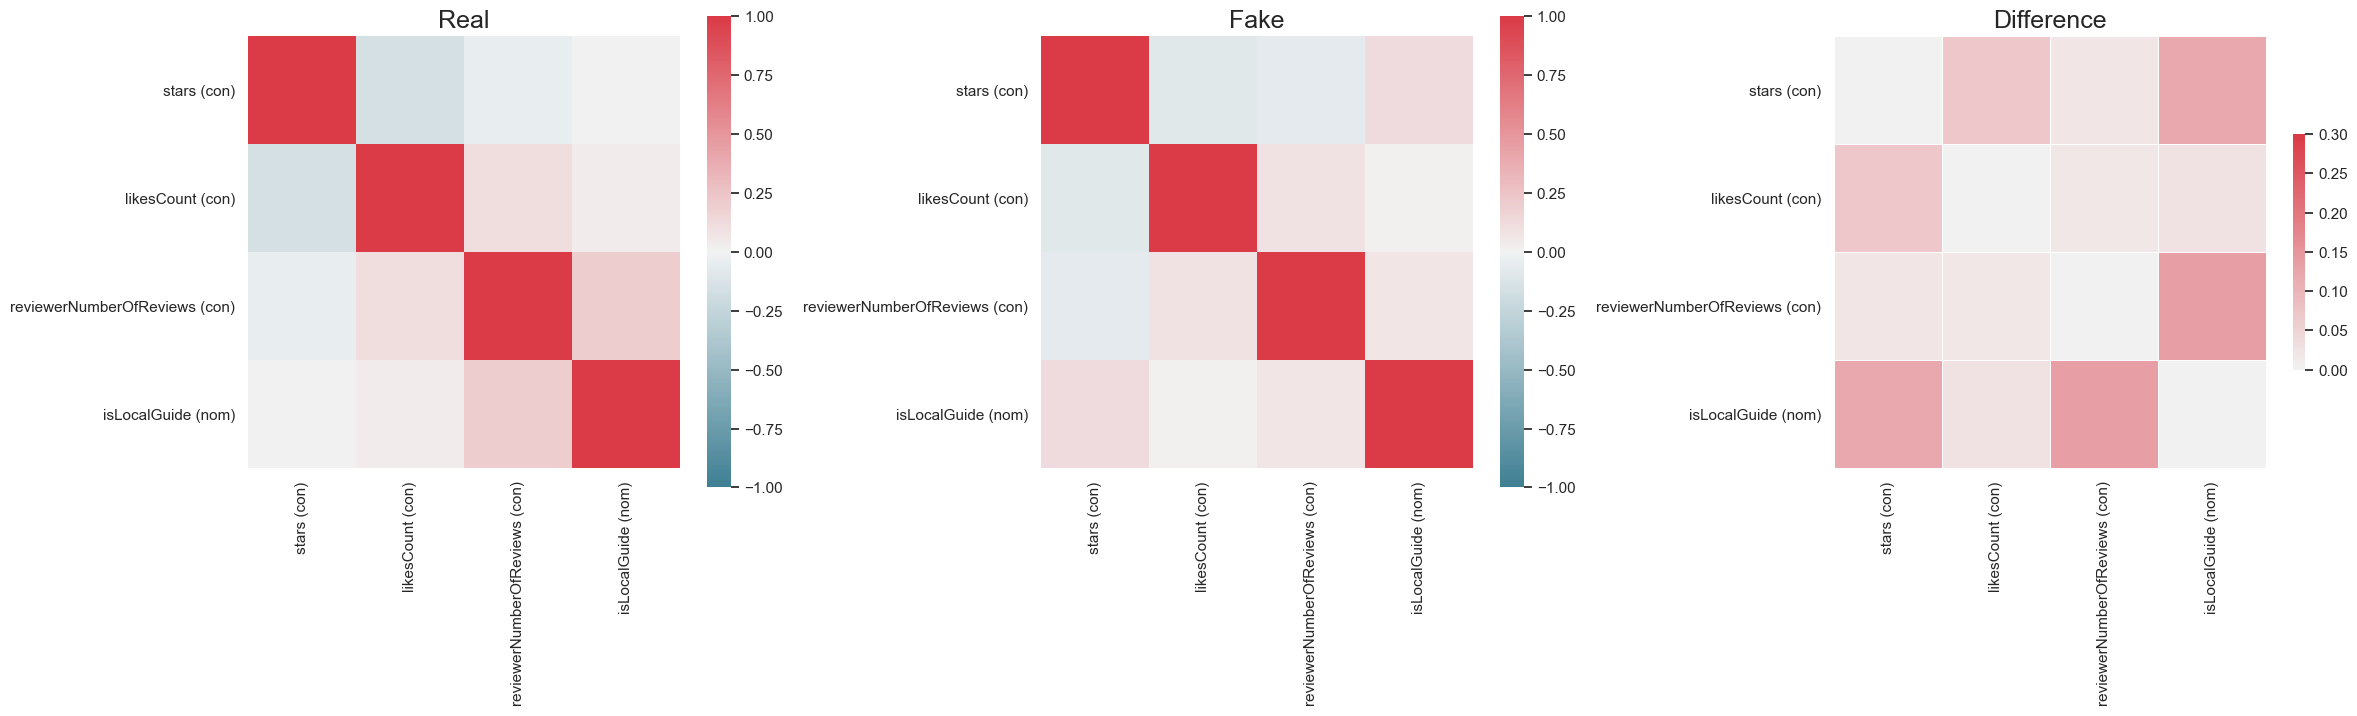

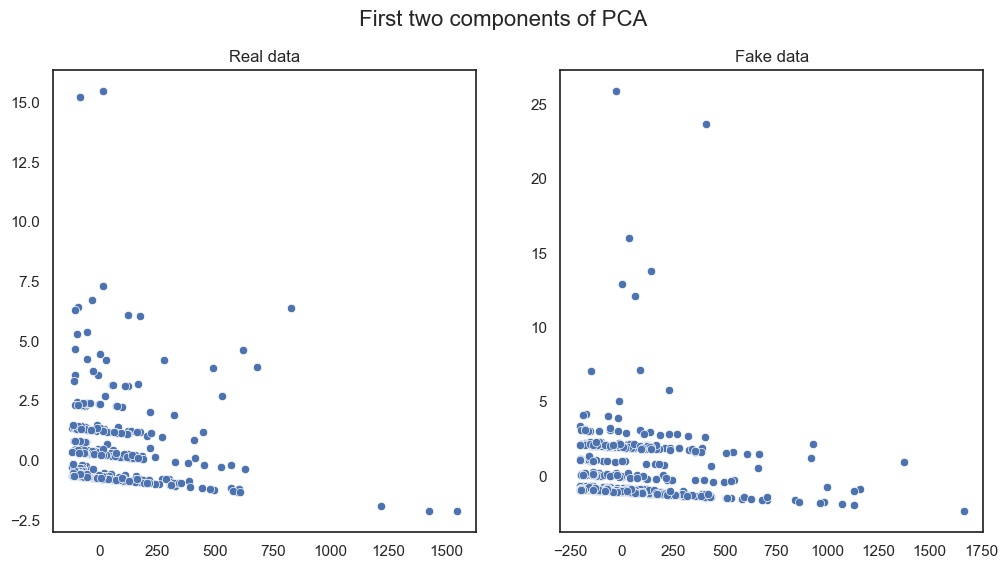

In [110]:
from table_evaluator import TableEvaluator

# drop the isLocalGuide column in both dataframes

samples = pd.read_csv('01_Data/raw_data/fake_metadata_ctgan_stars_likes_reviewernr_localguide.csv')
org_data = pd.read_csv('01_Data/raw_data/base_dataset_tabGAN.csv')
cols_to_keep = ['stars', 'likesCount', 'reviewerNumberOfReviews', 'isLocalGuide']

samples = samples[cols_to_keep]
org_data = org_data[cols_to_keep]

# convert to float64
samples['stars'] = samples['stars'].astype('float64')
samples['likesCount'] = samples['likesCount'].astype('float64')
samples['reviewerNumberOfReviews'] = samples['reviewerNumberOfReviews'].astype('float64')

org_data['stars'] = org_data['stars'].astype('float64')
org_data['likesCount'] = org_data['likesCount'].astype('float64')
org_data['reviewerNumberOfReviews'] = org_data['reviewerNumberOfReviews'].astype('float64')

print(org_data.shape, samples.shape)
cat_cols = ['isLocalGuide']

print(samples.columns)
table_evaluator = TableEvaluator(org_data, samples, cat_cols=cat_cols)


figure = table_evaluator.visual_evaluation()



In [114]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')
samples = pd.read_csv('01_Data/raw_data/fake_metadata_ctgan_stars_likes_reviewernr_localguide.csv')
print(df_fake.shape)
print(samples.shape)

df_fake['fake_likesCount'] = ""
df_fake['fake_reviewerNumberOfReviews'] = ""
df_fake['fake_isLocalGuide'] = ""
df_fake['fake_stars'] = ""

for index, row in df_fake.iterrows():
    print(f"Hinzufügen der Fake-Meta-Daten zu Reihe {index}")
    df_fake.at[index, 'fake_likesCount'] = samples['likesCount'][index]
    df_fake.at[index, 'fake_reviewerNumberOfReviews'] = samples['reviewerNumberOfReviews'][index]
    df_fake.at[index, 'fake_isLocalGuide'] = samples['isLocalGuide'][index]
    df_fake.at[index, 'fake_stars'] = samples['stars'][index]

print(f"Done! Shape: {df_fake.shape}")
#df_fake.to_csv('fake_base_gpt3_v23314_sent_dalle.csv', index=False)

(705, 57)
(705, 4)
Hinzufügen der Fake-Meta-Daten zu Reihe 0
Hinzufügen der Fake-Meta-Daten zu Reihe 1
Hinzufügen der Fake-Meta-Daten zu Reihe 2
Hinzufügen der Fake-Meta-Daten zu Reihe 3
Hinzufügen der Fake-Meta-Daten zu Reihe 4
Hinzufügen der Fake-Meta-Daten zu Reihe 5
Hinzufügen der Fake-Meta-Daten zu Reihe 6
Hinzufügen der Fake-Meta-Daten zu Reihe 7
Hinzufügen der Fake-Meta-Daten zu Reihe 8
Hinzufügen der Fake-Meta-Daten zu Reihe 9
Hinzufügen der Fake-Meta-Daten zu Reihe 10
Hinzufügen der Fake-Meta-Daten zu Reihe 11
Hinzufügen der Fake-Meta-Daten zu Reihe 12
Hinzufügen der Fake-Meta-Daten zu Reihe 13
Hinzufügen der Fake-Meta-Daten zu Reihe 14
Hinzufügen der Fake-Meta-Daten zu Reihe 15
Hinzufügen der Fake-Meta-Daten zu Reihe 16
Hinzufügen der Fake-Meta-Daten zu Reihe 17
Hinzufügen der Fake-Meta-Daten zu Reihe 18
Hinzufügen der Fake-Meta-Daten zu Reihe 19
Hinzufügen der Fake-Meta-Daten zu Reihe 20
Hinzufügen der Fake-Meta-Daten zu Reihe 21
Hinzufügen der Fake-Meta-Daten zu Reihe 22
Hi

In [116]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')

# print the first 5 rows of the dataframe
print(df_fake.head(20))

    stars  publishedAtDate  name  \
0     NaN              NaN   NaN   
1     NaN              NaN   NaN   
2     NaN              NaN   NaN   
3     NaN              NaN   NaN   
4     NaN              NaN   NaN   
5     NaN              NaN   NaN   
6     NaN              NaN   NaN   
7     NaN              NaN   NaN   
8     NaN              NaN   NaN   
9     NaN              NaN   NaN   
10    NaN              NaN   NaN   
11    NaN              NaN   NaN   
12    NaN              NaN   NaN   
13    NaN              NaN   NaN   
14    NaN              NaN   NaN   
15    NaN              NaN   NaN   
16    NaN              NaN   NaN   
17    NaN              NaN   NaN   
18    NaN              NaN   NaN   
19    NaN              NaN   NaN   

                                                 text  \
0   This was so funny, lots of games! I won an ado...   
1   Fun party experience with a wide range of game...   
2   This was such a fun place for the whole family...   
3   This place 

In [127]:
df_fake = pd.read_csv('fake_base_gpt3_v23314_sent_dalle.csv')

df_fake = df_fake.drop(columns=['likesCount', 'reviewerNumberOfReviews', 'isLocalGuide', 'publishedAtDate'])
df_fake = df_fake.rename(columns={'stars': 'org_stars'})

df_fake = df_fake.rename(columns={'fake_likesCount': 'likesCount', 'fake_reviewerNumberOfReviews': 'reviewerNumberOfReviews', 'fake_isLocalGuide': 'isLocalGuide', 'fake_stars': 'stars', 'fake_publishedAtDate': 'publishedAtDate'})

df_fake = df_fake.drop(columns=['categories/0', 'categories/1', 'categories/2', 'categoryName.1', 'reviewsCount', 'scrapedAt'])
print(df_fake.columns)
print(df_fake.shape)


df_fake.to_csv('fake_base_gpt3_v23314_sent_dalle_colReduced.csv', index=False)



Index(['org_stars', 'name', 'text', 'title', 'subTitle', 'description',
       'price', 'totalScore', 'reviewId', 'categoryName', 'reviewImageUrls/0',
       'reviewImageUrls/1', 'reviewImageUrls/2', 'reviewImageUrls/3',
       'reviewUrl', 'reviewerId', 'reviewerPhotoUrl', 'reviewerUrl', 'state',
       'street', 'temporarilyClosed', 'url', 'website', 'genre', 'keywords',
       'keywords_only', 'sentiment', 'sent_score_0', 'label', 'placeId',
       'text_length', 'prompt_v2', 'gpt3_v2', 'prompt_v3', 'gpt3_v3',
       'gpt3_v3.1', 'prompt_v4', 'gpt3_v4', 'sent_v2', 'sent_v3', 'sent_v3.1',
       'sent_v4', 'reviewIdF', 'dalle_prompt', 'githubUrls/0',
       'publishedAtDate', 'fake_name', 'likesCount', 'reviewerNumberOfReviews',
       'isLocalGuide', 'stars'],
      dtype='object')
(705, 51)
